# Progress and logging
> Callbacks to track progress of training or log results.

In [ ]:
#| default_exp callback.progress

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from wafer.basics import *

In [ ]:
from wafer.init import *

For demo, consider the image classification task on the MNIST dataset.

In [ ]:
dls = mk_dls_from_hub('mnist', get_xy=lambda o: (o['image'].unsqueeze(1).float(), o['label']), sz=[500, 500])

In [ ]:
def conv(ni, nf, ks=3, actn=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    return nn.Sequential(res, nn.ReLU()) if actn else res
def mk_tst_model():
    return nn.Sequential(
        conv(1, 8, ks=5),        #14x14
        conv(8, 16),             #7x7
        conv(16, 32),            #4x4
        conv(32, 64),            #2x2
        nn.Flatten(),
        nn.Linear(64*4, 10))

## Gradient flow

In [ ]:
#| export
class GradFlowCB(Callback):
    "A `Callback` that plots the mean and maximum magnitude of gradient in each layer for `every` iterations."
    order = 65
    
    def __init__(self, every: int=10, showbias: bool=False, figsize: tuple=(4,3)):
        self.every,self.showbias,self.figsize = every,showbias,figsize

    def before_fit(self):
        self.graph_out = None
        self.names,self.params = [],[]
        for n,p in self.learner.model.named_parameters():
            if p.requires_grad and ('bias' not in n or self.showbias):
                self.names.append(n)
                self.params.append(p)  # references
        
        if self.showbias: self.b_msk = np.array(['bias' in n for n in self.names])
        margin = 0.05
        self.xs = np.linspace(0, 1, len(self.names))
        self.graph_fig, self.graph_ax = plt.subplots(figsize=self.figsize)
        self.graph_ax.set_xlim(self.xs[0]-margin, self.xs[-1]+margin)
        self.graph_ax.set_xticks(self.xs, self.names, rotation='vertical')
        self.graph_ax.set_xlabel('layer')
        self.graph_ax.set_ylabel('|gradient|')
        self.graph_ax.set_title('Gradient flow')

    def before_epoch(self):
        if self.graph_out is None: self.graph_out = display(self.graph_ax.figure, display_id=True)
    
    def before_step(self):
        if self.every is not None and self.learner.n_iters % self.every == 0:
            self._clear_ax_data()
            self._update_graph()
    
    def after_fit(self):
        plt.close(self.graph_fig)
        
    def _clear_ax_data(self):
        for o in self.graph_ax.lines + self.graph_ax.collections: o.remove()
    
    def _update_graph(self):
        stats = []
        for p in self.params:
            stats.append([p.grad.abs().mean().item(), p.grad.abs().max().item()])
        stats = np.array(stats)
        xs,ax = self.xs,self.graph_ax
        if self.showbias:
            b_msk = self.b_msk
            ax.plot(xs[~b_msk], stats[~b_msk,0], 'd-', c='C1', label='weight_mean')
            ax.plot(xs[~b_msk], stats[~b_msk,1], '--', c='C1', label='weight_max')
            ax.fill_between(xs[~b_msk], stats[~b_msk,0], stats[~b_msk,1], color='C1', alpha=0.3)
            ax.plot(xs[b_msk], stats[b_msk,0], 'd-', c='C9', label='bias_mean')
            ax.plot(xs[b_msk], stats[b_msk,1], '--', c='C9', label='bias_max')
            ax.fill_between(xs[b_msk], stats[b_msk,0], stats[b_msk,1], color='C9', alpha=0.3)
        else:
            ax.plot(xs, stats[:,0], 'd-', c='C1', label='weight_mean')
            ax.plot(xs, stats[:,1], '--', c='C1', label='weight_max')
            ax.fill_between(xs, stats[:,0], stats[:,1], color='C1', alpha=0.3)
        # margin = 0.05
        # ax.set_ylim(stats.min()*(1-margin), stats.max()*(1+margin))
        ax.legend(loc=1, prop={'size':9})
        self.graph_out.update(ax.figure)

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
tst_model = mk_tst_model()
default_init(tst_model, verbose=True)

Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))                 | Xavier_normal, gain=1.
Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))                | He_normal, negative_slope=0.0
Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))               | He_normal, negative_slope=0.0
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))               | He_normal, negative_slope=0.0
Linear(in_features=256, out_features=10, bias=True)                             | He_normal, negative_slope=0.0


In [ ]:
opt = optim.SGD(tst_model.parameters(), 1e-3)
crit = nn.CrossEntropyLoss()
acc = MetricCB([MulticlassAccuracy(num_classes=10)], ['acc'])

learn = Learner(tst_model, dls, opt=opt, loss_func=crit, cbs=[acc, GradFlowCB(showbias=True)])

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

,train_loss,test_loss,acc
0,15.028039,6.586410,0.182
1,4.544245,4.355149,0.176
2,3.336907,3.708953,0.204
3,2.783426,3.209350,0.202
4,2.457581,2.958636,0.214


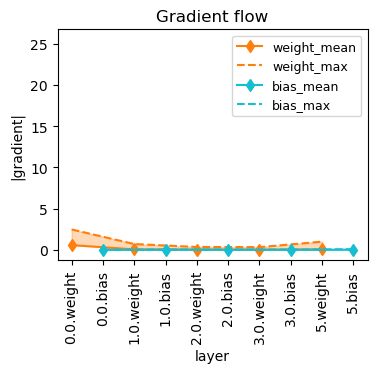

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
learn.fit(5)

Two utility functions `plot_grad_flow` and `plot_grad_flow_box` are also available. To be used without a `Learner`.

In [ ]:
#| export
def plot_grad_flow(m: nn.Module, ax: plt.Axes=None, showbias: bool=False, figsize: tuple=(4,3)):
    "Gradient flow plot. Showing mean and maximum magnitude of gradient in each layer. Use just after `loss.backward()`."
    names = []
    stats = []
    for n,p in m.named_parameters():
        if p.requires_grad and ('bias' not in n or showbias):
            names.append(n)
            stats.append([p.grad.abs().mean().item(), p.grad.abs().max().item()])
    stats = np.array(stats)
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    xs = np.linspace(0, 1, len(names))
    if showbias:
        b_msk = np.array(['bias' in n for n in names])
        ax.plot(xs[~b_msk], stats[~b_msk,0], 'd-', c='C1', label='weight_mean')
        ax.plot(xs[~b_msk], stats[~b_msk,1], '--', c='C1', label='weight_max')
        ax.fill_between(xs[~b_msk], stats[~b_msk,0], stats[~b_msk,1], color='C1', alpha=0.3)
        ax.plot(xs[b_msk], stats[b_msk,0], 'd-', c='C9', label='bias_mean')
        ax.plot(xs[b_msk], stats[b_msk,1], '--', c='C9', label='bias_max')
        ax.fill_between(xs[b_msk], stats[b_msk,0], stats[b_msk,1], color='C9', alpha=0.3)
    else:
        ax.plot(xs, stats[:,0], 'd-', c='C1', label='weight_mean')
        ax.plot(xs, stats[:,1], '--', c='C1', label='weight_max')
        ax.fill_between(xs, stats[:,0], stats[:,1], color='C1', alpha=0.3)
    margin = 0.05
    ax.set_xlim(xs[0]-margin, xs[-1]+margin)
    ax.set_ylim(stats.min()*(1-margin), stats.max()*(1+margin))
    ax.set_xticks(xs, names, rotation='vertical')
    ax.set_xlabel('layer')
    ax.set_ylabel('|gradient|')
    ax.set_title('Gradient flow')
    ax.legend(loc=1, prop={'size':9})

In [ ]:
#| export
def plot_grad_flow_box(m: nn.Module, ax: plt.Axes=None, showbias: bool=False, figsize: tuple=(4,3)):
    "Gradient flow plot. Boxplot. Use just after `loss.backward()`."
    names = []
    grads = []
    for n,p in m.named_parameters():
        if p.requires_grad and ('bias' not in n or showbias):
            names.append(n)
            grads.append(p.grad.detach().cpu().ravel())
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    xs = np.linspace(0, 1, len(names))
    style_dict = lambda c: {'widths': .08, 'showmeans': True, 'showfliers': False, 'patch_artist': True,
                            'meanprops': dict(marker='d', markeredgecolor=c[1],markerfacecolor=c[1]),
                            'medianprops': dict(color=c[1], linewidth=1.),
                            'boxprops': dict(facecolor=c[0], edgecolor=c[1], linewidth=1.),
                            'whiskerprops': dict(color=c[1], linewidth=1.),
                            'capprops': dict(color=c[1], linewidth=1.)}
    if showbias:
        b_msk = np.array(['bias' in n for n in names])
        ax.boxplot([g for i,g in enumerate(grads) if not b_msk[i]], positions=xs[~b_msk], **style_dict(['moccasin','C1']))
        ax.boxplot([g for i,g in enumerate(grads) if b_msk[i]], positions=xs[b_msk], **style_dict(['paleturquoise','C9']))
    else:
        ax.boxplot(grads, positions=xs, **style_dict(['moccasin','C1']))
    margin = 0.1
    ax.set_xlim(xs[0]-margin, xs[-1]+margin)
    ax.set_xticks(xs, names, rotation='vertical')
    ax.set_xlabel('layer')
    ax.set_ylabel('gradient')
    ax.set_title('Gradient flow')

## Stats

In [ ]:
#| export
class StatsCB(Callback):
    "A `Callback` that records mean, std, near_zero and _gradident_ of each layer for `every` iterations."
    order=-20
    
    def __init__(self, every: int=10, grad: bool=False):
        self.every,self.grad = every,grad
    
    def before_fit(self):
        "Add all submodules."
        self.names,self.layers = [],[]
        for n,m in self.learner.model.named_modules():
            if not has_children(m) and has_params(m):
                self.names.append(f"{n}.{type(m).__name__}")
                self.layers.append(m)
        self.stats = {'act': [], 'grad': [], 'iter': []}

    def before_batch(self):
        if self.every is None: return
        if self.learner.training and self.learner.n_iters % self.every == 0:
            self._register_hooks()
            self.stats['iter'].append(self.learner.n_iters)

    def before_step(self):
        if not self.grad: return
        if self.every is not None and self.learner.n_iters % self.every == 0:
            grad_stats = []
            for m in self.layers:
                m_stats = []
                for n,p in m._parameters.items():
                    if p is not None:
                        # params name, mean, max
                        m_stats.append([n, p.grad.abs().mean().item(), p.grad.abs().max().item()])
                grad_stats.append(m_stats)
            self.stats['grad'].append(grad_stats)
                        
    def after_batch(self):
        if self.every is None: return
        if self.learner.training and self.learner.n_iters % self.every == 0:
            self.stats['act'].append(self.hooks.stored)
            self._remove_hooks()

    def plot_layer(self, idx, axs=None, figsize=(11,3)):
        if not hasattr(self, 'stats'): return
        assert idx < len(self.names), f"index {idx} out of range {len(self.names)-1}."
        if axs is None:
            if self.grad:
                fig,axs = plt.subplots(1,4,figsize=figsize)
            else:
                fig,axs = plt.subplots(1,3,figsize=figsize)
        if axs.ndim > 1: axs = axs.flatten()
        xs = self.stats['iter']
        # Layer activation stats
        lacts = [o[idx] for o in self.stats['act']]
        lacts = [[o[n] for o in lacts] for n in ['mean', 'std', 'near_zero']]
        for i,title in enumerate(['mean', 'std', 'near zero(%)']):
            axs[i].plot(xs, lacts[i], '-', c='C1')
            axs[i].set_xlabel('iteration')
            axs[i].set_title(title)
        axs[2].set_ylim(-0.05,1.05)
        # Layer gradient stats
        if self.grad:
            lgrads = [o[idx] for o in self.stats['grad']]
            pnames = [o[0] for o in lgrads[0]]
            lgrads = np.vstack([[ooi for oo in o for ooi in oo[1:]] for o in lgrads])
            colors = plt.get_cmap('tab20')(np.linspace(0,1,len(pnames)))
            for i,n in enumerate(pnames):
                axs[-1].plot(xs, lgrads[:,i*2], '-', c=colors[i], label=n+'_mean')
                axs[-1].plot(xs, lgrads[:,i*2+1], '--', c=colors[i], label=n+'_max')
                axs[-1].fill_between(xs, lgrads[:,i*2], lgrads[:,i*2+1], color=colors[i], alpha=0.3)
            axs[-1].set_xlabel('iteration')
            axs[-1].set_title('gradient')
            axs[-1].legend(loc=1, prop={'size': 9})
        # Figure title
        try:
            fig.suptitle(self.names[idx])
            fig.tight_layout()
        except:
            pass
    
    def hook_fn(self, m, i, o):
        if isinstance(o, tuple): return self.hook_multi_ouput(o)
        o = o.float()
        res = {'mean': o.mean().item(), 'std': o.std().item(),
               'near_zero': (o.abs()<=0.01).long().sum().item()/o.numel()}
        return res

    def hook_multi_ouput(self,o_tuple):
        "For outputs of RNN which are [nested] tuples of tensors"
        res = []
        for o in self._flatten_tuple(o_tuple):
            if not isinstance(o, torch.Tensor): continue
            res.append(self.hook_fn(None, None, o))
        return res

    def _flatten_tuple(self, o_tuple):
        "Recursively flatten a [nested] tuple"
        res = []
        for it in o_tuple:
            if isinstance(it, tuple): res += self._flatten_tuple(it)
            else: res += [it]
        return tuple(res)
    
    def _register_hooks(self): self.hooks = Hooks(self.layers, self.hook_fn)
    def _remove_hooks(self):
        if getattr(self, 'hooks', None): self.hooks.remove()
        

In [ ]:
tst_model = mk_tst_model()
default_init(tst_model)

In [ ]:
opt = optim.SGD(tst_model.parameters(), 1e-3)
lstats = StatsCB(grad=True)
learn = Learner(tst_model, dls, opt=opt, loss_func=crit, cbs=[acc, lstats])

In [ ]:
learn.fit(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

,train_loss,test_loss,acc
0,13.820824,4.479413,0.188
1,3.331656,3.248346,0.224
2,2.535739,2.850029,0.266
3,2.195015,2.629070,0.282
4,1.948858,2.474607,0.318


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]

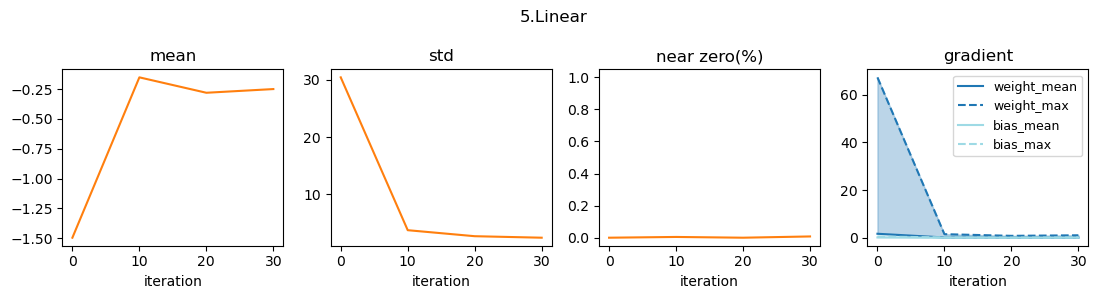

In [ ]:
lstats.plot_layer(-1)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()